In [1]:
"""Implementations of algorithms for continuous control."""
import functools
from jaxrl_m.typing import *

import jax
import jax.lax as lax
import jax.numpy as jnp
import numpy as np
import optax
from jaxrl_m.common import TrainState, target_update, nonpytree_field
from jaxrl_m.networks import Policy, Critic, ensemblize

import flax
import flax.linen as nn
from functools import partial

NUM_ROLLOUTS = 8
NUM_CRITICS = 5

class Temperature(nn.Module):
    initial_temperature: float = 1e-3

    
    @nn.compact
    def __call__(self) -> jnp.ndarray:
        log_temp = self.param('log_temp',
                              init_fn=lambda key: jnp.full(
                                  (), self.initial_temperature))
        old_entropy = self.param('old_entropy',
                              init_fn=lambda key: jnp.full(
                                  (), 0.))
        return jnp.abs(log_temp)
        

class SACAgent(flax.struct.PyTreeNode):
    rng: PRNGKey
    critic: TrainState
    target_critic: TrainState
    actor: TrainState
    temp: TrainState
    config: dict = nonpytree_field()
    
    
    @jax.jit    
    def reset_critic_optimizer(agent):
    
        new_opt_state = agent.critic.tx.init(agent.critic.params)
        new_critic = agent.critic.replace(opt_state=new_opt_state)
        
        return agent.replace(critic=new_critic)

    @partial(jax.jit,static_argnames=('num_steps',))  
    def update_many_critics(agent,transitions: Batch,idxs:jnp.array,num_steps:int,R2):

        def update_one_critic(critic,idxs,
                            agent,transitions,num_steps):
            
            def one_update(agent,critic,batch: Batch):
                                  
                def critic_loss_fn(critic_params):
                            
                            
                            next_dist = agent.actor(batch['next_observations'])
                            next_actions, next_log_probs = next_dist.sample_and_log_prob(seed=next_key)

                            next_q_r,next_q_e = agent.critic(batch['next_observations'], next_actions,True,params=critic_params)
                            q_r,q_e = agent.critic(batch['observations'], batch['actions'],True,params=critic_params)
                            
                            target_q_r = batch['rewards'] + agent.config['discount'] * batch['masks'] *next_q_r 
                            target_q_e =  batch['discounts'] * batch['masks'] *(next_q_e - agent.temp() * next_log_probs)
                             
                            target_q_e = jax.lax.stop_gradient(target_q_e)
                            target_q_r = jax.lax.stop_gradient(target_q_r)
                            
                            critic_loss = ((target_q_r-q_r)**2 + (target_q_e-q_e)**2).mean() 
                            
                            return critic_loss, {
                            'critic_loss': critic_loss,
                            'q1': q_r.mean(),
                        }  
                    
        
                new_critic, critic_info = critic.apply_loss_fn(loss_fn=critic_loss_fn, has_aux=True)
                
                return agent,new_critic
            
            
            get_batch = lambda transitions,idx : jax.tree_map(lambda x : x[idx],transitions)
                
            agent,new_critic = jax.lax.fori_loop(0, num_steps, 
                        lambda i, args: one_update(*args,get_batch(transitions,idxs[i])),
                        (agent,critic))
            
            return new_critic
        
        
        new_rng, curr_key, next_key = jax.random.split(agent.rng, 3)
        critic = agent.critic
        
        ###### Reset critic params ######
        
        reset = lambda rng,params : critic.init(rng,
                                                agent.config["observations"], agent.config["actions"],False)["params"]
        no_reset = lambda rng,params: params
        f = lambda  mask,rng,params :lax.cond(mask,reset,no_reset,rng,params)
        mask = jnp.zeros((NUM_CRITICS))
        mask.at[jnp.argmin(R2)].set(1)
        rngs = jax.random.split(agent.rng, NUM_CRITICS)
        critic_params = jax.vmap(f,in_axes=(0,0,0))(mask,rngs,critic.params)
        ###################################
        critic_def = Critic((256,256))
        critics = jax.vmap(TrainState.create,in_axes=(None,0,None))(critic_def,critic_params,optax.adam(learning_rate=3e-4))
        tmp = partial(update_one_critic,agent=agent,transitions=transitions,num_steps=num_steps)
        new_critics = jax.vmap(tmp,in_axes=(0,0))(critics,idxs)
        agent = agent.replace(rng=new_rng,critic=new_critics)
        
        return agent,{}
    
    

        
    @jax.jit
    def update_actor(agent, batch: Batch,R2):
        new_rng, curr_key, next_key = jax.random.split(agent.rng, 3)

        def actor_loss_fn(actor_params,R2):
            observations = jnp.repeat(batch['observations'], 10, axis=0)
            discounts = jnp.repeat(batch['discounts'], 10, axis=0)
            masks = jnp.int32(jnp.repeat(batch['masks'], 10, axis=0))

            dist = agent.actor(observations, params=actor_params)
            actions, log_probs = dist.sample_and_log_prob(seed=curr_key)
            call_one_critic = lambda observations,actions,params : agent.critic(observations,actions,params=params)
            q_r_all,q_e_all = jax.vmap(call_one_critic,in_axes=(None,None,0))(observations, actions,agent.critic.params)##critic_update_info
            
            q_weights = jax.nn.softmax(R2,axis=0)
            q_r = jnp.sum(q_weights.reshape(-1,1)*q_r_all,axis=0)
            q_e = jnp.mean(q_e_all,axis=0)
            q = q_r + q_e
            
            actor_loss = (discounts*(log_probs * agent.temp() - q)).sum()/discounts.sum()
            actor_loss = (log_probs * agent.temp() - q).mean()
            # lr_bonus = jnp.exp(jnp.max(R2))/jnp.exp(1)
            # actor_loss = actor_loss*lr_bonus
           
            return actor_loss, {
                'actor_loss': actor_loss,
                'entropy': -1 * ((discounts*log_probs)/(discounts.sum())).sum(),
                #'entropy': -1 * log_probs.mean(),
            }
        
        
        def temp_loss_fn(temp_params, entropy, target_entropy):
            temperature = agent.temp(params=temp_params)
            old_entropy = temp_params['old_entropy']
            entropy_diff = entropy-target_entropy
            entropy_shift = entropy - old_entropy
            temp_loss = temperature * jax.lax.stop_gradient(entropy_diff + entropy_shift)
            #temp_loss = temperature * jax.lax.stop_gradient(entropy_diff)
            return temp_loss, {
                'temp_loss': temp_loss,
                'temperature': agent.temp(),
                'entropy_diff': entropy_diff,
                'entropy': entropy,

            }

        loss_fn = partial(actor_loss_fn,R2=R2)
        
        new_actor, actor_info = agent.actor.apply_loss_fn(loss_fn=loss_fn, has_aux=True)
        actor_info["old_entropy"] = agent.temp.params["old_entropy"]
        temp_loss_fn = functools.partial(temp_loss_fn, entropy=actor_info['entropy'], target_entropy=agent.config['target_entropy'])
        new_temp, temp_info = agent.temp.apply_loss_fn(loss_fn=temp_loss_fn, has_aux=True)
        new_temp.params["log_temp"]=jnp.clip(new_temp.params["log_temp"],1e-6,1)
        new_temp.params["old_entropy"] = temp_info['entropy']
        
        agent = agent.replace(rng=new_rng, temp=new_temp)
        new_actor, actor_info = agent.actor.apply_loss_fn(loss_fn=loss_fn, has_aux=True)
        
        return agent.replace(rng=new_rng, actor=new_actor), {**actor_info, **temp_info}

    @jax.jit
    def sample_actions(agent,   
                       observations: np.ndarray,
                       seed: PRNGKey,
                       random = bool,
                       temperature: float = 1.0,
                       ) -> jnp.ndarray:
        actions = agent.actor(observations, temperature=temperature).sample(seed=seed)
        
        return actions



def create_learner(
                 seed: int,
                 observations: jnp.ndarray,
                 actions: jnp.ndarray,
                 actor_lr: float = 3e-4,
                 critic_lr: float = 3e-4,
                 temp_lr: float =3e-1,## Test
                 hidden_dims: Sequence[int] = (256, 256),
                 discount: float = 0.99,
                 tau: float = 0.005,
                 target_entropy: float = None,
                 backup_entropy: bool = True,
            **kwargs):

        print('Extra kwargs:', kwargs)

        rng = jax.random.PRNGKey(seed)
        rng, actor_key, critic_key = jax.random.split(rng, 3)

        action_dim = actions.shape[-1]
        actor_def = Policy((256,256), action_dim=action_dim, 
            log_std_min=-10.0, state_dependent_std=True, tanh_squash_distribution=True, final_fc_init_scale=1.0)

        
        critic_def = Critic(hidden_dims)
        critic_keys  = jax.random.split(critic_key, NUM_CRITICS)
        critic_params = jax.vmap(critic_def.init,in_axes=(0,None,None))(critic_keys, observations, actions)['params']
        critics = jax.vmap(TrainState.create,in_axes=(None,0,None))(critic_def,critic_params,optax.adam(learning_rate=3e-4))

        actor_params = actor_def.init(actor_key, observations)['params']
        actor = TrainState.create(actor_def, actor_params, tx=optax.adam(learning_rate=3e-4,b1=0.5))
        #actor = TrainState.create(actor_def, actor_params, tx=optax.rmsprop(learning_rate=3e-4))
        
        temp_def = Temperature()
        temp_params = temp_def.init(rng)['params']
        #temp = TrainState.create(temp_def, temp_params, tx=optax.sgd(learning_rate=1e-3))
        temp = TrainState.create(temp_def, temp_params, tx=optax.sgd(learning_rate=1e-3))
    
        if target_entropy is None:
            target_entropy = - action_dim

        config = flax.core.FrozenDict(dict(
            discount=discount,
            target_update_rate=tau,
            target_entropy=target_entropy,
            backup_entropy=backup_entropy,  
            observations=observations,
            actions=actions,          
        ))

        return SACAgent(rng, critic=critics, target_critic=critics, actor=actor, temp=temp, config=config)



In [2]:
import os
from functools import partial
import numpy as np
import jax
import tqdm
import gymnasium as gym


from jaxrl_m.wandb import setup_wandb, default_wandb_config, get_flag_dict
import wandb
from jaxrl_m.evaluation import supply_rng, evaluate, flatten, EpisodeMonitor
from jaxrl_m.dataset import ReplayBuffer
from collections import deque
from jax import config
from jaxrl_m.utils import flatten_rollouts
from jaxrl_m.evaluate_critic import evaluate_many_critics
# config.update("jax_debug_nans", True)
# config.update("jax_enable_x256", True)
        
from jaxrl_m.rollout import rollout_policy2,rollout_policy

env_name='Hopper-v4'
seed=np.random.choice(1000000)
eval_episodes=10
batch_size = 256
max_steps = int(1e6)
start_steps = 10000                 
log_interval = 5000

wandb_config = {
    'project': 'disc_actornexplo_9925_8',
    'name': 'sac_{env_name}_{seed}'.format(env_name=env_name, seed=seed),
    'hyperparam_dict':{'env_name':env_name,'seed':seed},
}

env = EpisodeMonitor(gym.make(env_name,max_episode_steps=625))
eval_env = EpisodeMonitor(gym.make(env_name))
setup_wandb(**wandb_config) 

example_transition = dict(
    observations=env.observation_space.sample(),
    actions=env.action_space.sample(),
    rewards=0.0,
    masks=1.0,
    next_observations=env.observation_space.sample(),
    discounts=1.0,
)

replay_buffer = ReplayBuffer.create(example_transition, size=int(1_000_000))
actor_buffer = ReplayBuffer.create(example_transition, size=int(10e3))

agent = create_learner(seed,
                example_transition['observations'][None],
                example_transition['actions'][None],
                max_steps=max_steps,
                #**FLAGS.config
                )

exploration_metrics = dict()
obs,info = env.reset()    
exploration_rng = jax.random.PRNGKey(0)
i = 0
unlogged_steps = 0
policy_rollouts = deque([], maxlen=30)
warmup = True
R2 = jnp.ones(NUM_CRITICS)

with tqdm.tqdm(total=max_steps) as pbar:
    
    while (i < max_steps):

        warmup=(i < start_steps)
        replay_buffer,actor_buffer,policy_rollout,policy_return,variance,undisc_policy_return,num_steps = rollout_policy(
                                                                agent,env,exploration_rng,
                                                                replay_buffer,actor_buffer,warmup=warmup,
                                                                num_rollouts=NUM_ROLLOUTS,random=False,
                                                                )
        
        if not warmup : policy_rollouts.append(policy_rollout)
        unlogged_steps += num_steps
        i+=num_steps
        pbar.update(num_steps)
            
        if replay_buffer.size > start_steps and len(policy_rollouts)>0:
        
            ### Update critics ###
            transitions = replay_buffer.get_all()
            tmp = partial(jax.random.choice,a=replay_buffer.size, shape=(5000,512), replace=True)
            idxs = jax.vmap(tmp)(jax.random.split(agent.rng, NUM_CRITICS))
            agent, critic_update_info = agent.update_many_critics(transitions,idxs,5000,R2)

            ### Update critic weights ## 
            if len(policy_rollouts)>=10:  
                #with jax.default_matmul_precision('bfloat16'):
                                          
                    flattened_rollouts = flatten_rollouts(policy_rollouts)
                    R2,bias = evaluate_many_critics(agent,policy_rollout.policy_return,flattened_rollouts)
   
            ### Update actor ###
            actor_batch = actor_buffer.get_all()      
            agent, actor_update_info = agent.update_actor(actor_batch,R2)    
            update_info = {**critic_update_info, **actor_update_info}
            
            ### Log training info ###
            exploration_metrics = {f'exploration/disc_return': policy_return,'training/std': jnp.sqrt(variance)}
            train_metrics = {f'training/{k}': v for k, v in update_info.items()}
            train_metrics['training/undisc_return'] = undisc_policy_return
            
            wandb.log(train_metrics, step=int(i),commit=False)
            wandb.log(exploration_metrics, step=int(i),commit=False)
            if len(policy_rollouts)>=10:
                R2_train_info = {'R2/max': jnp.max(R2),'R2/bias': bias[jnp.argmax(R2)],
                                "R2/histogram": wandb.Histogram(jnp.clip(R2,a_min=-1,a_max=1)),
                                }
                wandb.log(R2_train_info, step=int(i),commit=False)
            
            ### Log evaluation info ###
            
            if unlogged_steps > log_interval:
                
            
                _,_,_,disc_policy_return,_,undisc_policy_return_e,_ = rollout_policy(agent,eval_env,exploration_rng,
                                                                    None,None,warmup=False,
                                                                    num_rollouts=10,random=False,
                                                                )
                eval_info = {'disc_policy_return': disc_policy_return,'undisc_policy_return': undisc_policy_return_e}
                eval_metrics = {f'evaluation/{k}': v for k, v in eval_info.items()}
                wandb.log(eval_metrics, step=int(i),commit=True)
            
                
                unlogged_steps = 0

2024-02-27 19:40:44.984493: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin


Extra kwargs: {'max_steps': 1000000}


1000768it [1:07:41, 246.40it/s]                            


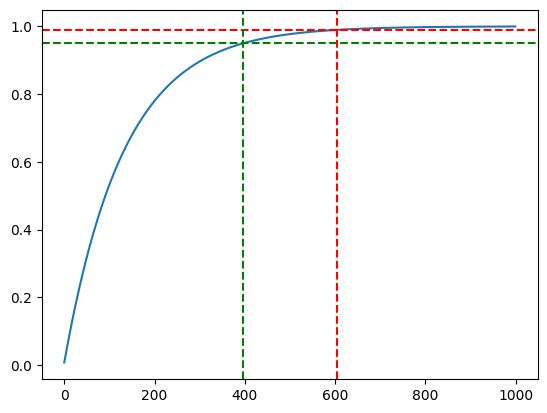

: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

disc = 0.9925
rslt = [disc**i for i in range(1000)]
plt.plot(np.cumsum(rslt)/np.sum(rslt))
plt.axhline(y=0.95, color='green', linestyle='dashed')
plt.axhline(y=0.99, color='red', linestyle='dashed')
x_95 = np.argmax(np.cumsum(rslt)/np.sum(rslt) > 0.95)
x_99 = np.argmax(np.cumsum(rslt)/np.sum(rslt) > 0.99)

plt.axvline(x=x_95, color='green', linestyle='dashed')
plt.axvline(x=x_99, color='red', linestyle='dashed')
plt.show()

plt.show()
